<a href="https://colab.research.google.com/github/jdmartinezrs/MachineLearningAlgoritms/blob/main/KNeighborsClassifierKvalidationCurvaAprendizajeAprobado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
sheet_id = "1r4szNXN8abPstdpZEtuePc89H6AJPgjq"
sheet_url = f"https://drive.google.com/uc?id={sheet_id}&export=csv"
df = pd.read_csv(sheet_url)

In [3]:
df.rename(columns={
    'Ult Km/Hr': 'Ult_Km',
    'Tipo de Vehiculo': 'Tipo_Vehiculo',
    'Km/Hr Pend': 'Km_Pend',
    'Progreso': 'Progreso'
}, inplace=True)

# Crear la columna objetivo en 3 cuantiles
df['Km_Pend_cls'] = pd.qcut(
    df['Km_Pend'],
    q=3,
    labels=['Bajo', 'Medio', 'Alto']
)

# Separar features y target
features = ['Ult_Km', 'Tipo_Vehiculo', 'Progreso']
X = df[features]
y = df['Km_Pend_cls']

In [40]:
# Split de entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), ['Ult_Km', 'Progreso']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Tipo_Vehiculo'])
])

# Pipeline con KNN (K=3)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=13))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Ult_Km', 'Progreso']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Tipo_Vehiculo'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=13))])

=== PRIMER REPORTE (test 20 %) ===
              precision    recall  f1-score   support

        Alto       0.98      0.94      0.96        67
        Bajo       0.97      0.94      0.95        67
       Medio       0.89      0.95      0.92        66

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.94      0.95       200



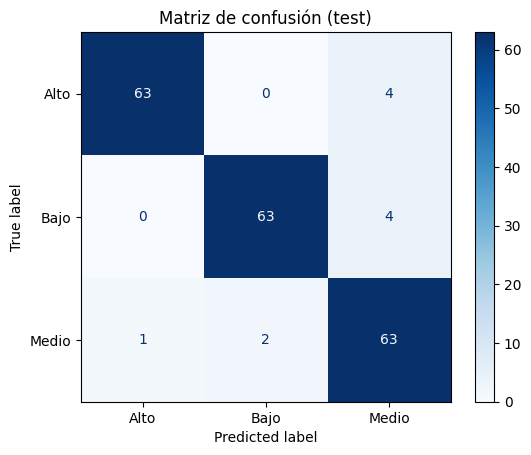

[[63  0  4]
 [ 0 63  4]
 [ 1  2 63]]


In [41]:
# Entrenar modelo y primera evaluación (set de prueba)

y_pred = model.predict(X_test)

print("=== PRIMER REPORTE (test 20 %) ===")
print(classification_report(y_test, y_pred, digits=2))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap='Blues')
plt.title('Matriz de confusión (test)')
plt.show()
print(cm)


In [34]:
# Comparar rendimiento entrenamiento vs. prueba
y_train_pred = model.predict(X_train)

print("=== ENTRENAMIENTO ===")
print(classification_report(y_train, y_train_pred, digits=2))
print("Accuracy train:", accuracy_score(y_train, y_train_pred))

print("\n=== PRUEBA ===")
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy test :", accuracy_score(y_test,  y_pred))


=== ENTRENAMIENTO ===
              precision    recall  f1-score   support

        Alto       0.97      0.99      0.98       267
        Bajo       0.98      0.99      0.99       266
       Medio       0.98      0.94      0.96       267

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Accuracy train: 0.97625

=== PRUEBA ===
              precision    recall  f1-score   support

        Alto       0.97      0.97      0.97        67
        Bajo       0.97      0.93      0.95        67
       Medio       0.90      0.94      0.92        66

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.95       200
weighted avg       0.95      0.94      0.95       200

Accuracy test : 0.945


In [35]:

# Validación cruzada estratificada (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy CV 5-fold: %.3f ± %.3f" % (cv_scores.mean(), cv_scores.std()))


Accuracy CV 5-fold: 0.944 ± 0.016


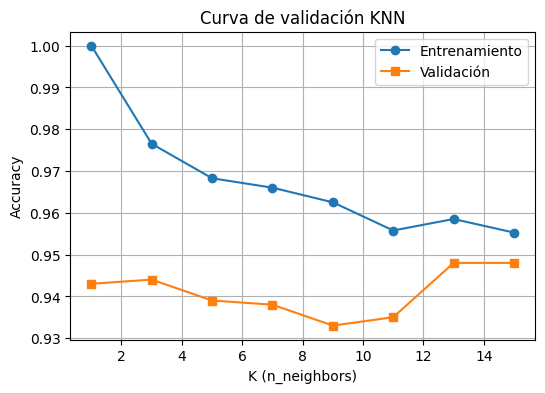

K= 1  train=1.000  test=0.943
K= 3  train=0.976  test=0.944
K= 5  train=0.968  test=0.939
K= 7  train=0.966  test=0.938
K= 9  train=0.963  test=0.933
K=11  train=0.956  test=0.935
K=13  train=0.959  test=0.948
K=15  train=0.955  test=0.948


In [36]:

# Curva de validación para seleccionar el mejor K
import numpy as np
param_range = np.arange(1, 16, 2)   # K = 1,3,5,...,15

train_scores, test_scores = validation_curve(
    model,
    X, y,
    param_name='classifier__n_neighbors',
    param_range=param_range,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(param_range, train_mean, marker='o', label='Entrenamiento')
plt.plot(param_range, test_mean,  marker='s', label='Validación')
plt.xlabel('K (n_neighbors)')
plt.ylabel('Accuracy')
plt.title('Curva de validación KNN')
plt.grid(True)
plt.legend()
plt.show()

for k, tr, ts in zip(param_range, train_mean, test_mean):
    print(f"K={k:2d}  train={tr:.3f}  test={ts:.3f}")


In [37]:

# Predicción de un ejemplo manual
nuevo_ejemplo = pd.DataFrame([{
   'Ult_Km': 278223,
    'Tipo_Vehiculo': 'IRRIGADOR',
    'Progreso': 0.6435
}])

print("El riesgo de daño del vehículo es:",
      model.predict(nuevo_ejemplo)[0])


El riesgo de daño del vehículo es: Medio


In [42]:

codigo_equipo_a_consultar = 'VE-DT-HR-XMD957'


filtered_row = df[df['CODIGO DE EQUIPO'] == codigo_equipo_a_consultar]

if not filtered_row.empty:

    km_pend_cls_value = filtered_row['Km_Pend_cls'].iloc[0]
    print(f"CODIGO DE EQUIPO '{codigo_equipo_a_consultar}', Km_Pend_cls is: {km_pend_cls_value}")
else:
    print(f"No data found for CODIGO DE EQUIPO '{codigo_equipo_a_consultar}'.")

CODIGO DE EQUIPO 'VE-DT-HR-XMD957', Km_Pend_cls is: Medio


Datos con **etiquetas** o respuestas conocidas

In [ ]:
df[df['Km_Pend_cls'] == 'Medio'].sample(5)


,Fecha,ITEM,CODIGO DE EQUIPO,Tipo_Vehiculo,fecha de revision,Km/ Hr Plan,Fecha Ult Pre-Operacional,Dias Pend,Ult_Km,Km/Hr Cambio,Fecha Cambio,Fecha Prox Cambio,Unnamed: 12,Km/Hr Proyectada,Km_Pend,Progreso,Unnamed: 16,Observaciones,Km_Pend_cls
850,2024-12-17,851,VE-DT-HR-XMD957,IRRIGADOR,2024-12-17,10000.0,2024-10-22,56,278223,264184,2024-03-31,2025-04-03,2025-09-30,284658.0,6435.0,0.6435,up,Suddenly maybe discussion sit no make.,Medio
976,2024-10-03,977,VE-DT-CM-XMD265,IRRIGADOR,2024-10-03,10000.0,2023-09-18,381,343324,339215,2023-06-17,2025-01-07,2025-07-06,349269.0,5945.0,0.5945,election,Leader reveal turn seat hit allow.,Medio
734,2025-01-27,735,VE-DT-CH-XMD804,DOBLETROQUE,2025-01-27,10000.0,2023-06-10,597,211987,207290,2022-09-29,2025-05-11,2025-11-07,217184.0,5197.0,0.5197,nothing,Someone size rock popular heavy go close.,Medio
413,2024-08-29,414,VE-DT-CM-XMD262,IRRIGADOR,2024-08-29,10000.0,2023-08-27,368,196503,183725,2023-05-03,2025-07-20,2026-01-16,200472.0,3969.0,0.3969,fact,Southern police record there role including.,Medio
428,2024-12-06,429,VE-DT-HR-XMD772,CARRO TANQUE,2024-12-06,10000.0,2024-07-08,151,328123,318447,2024-01-24,2025-06-09,2025-12-06,332136.0,4013.0,0.4013,line,Believe sometimes writer wait better cost.,Medio


In [ ]:
df[df['Km_Pend_cls'] == 'Alto'].sample(5)

,Fecha,ITEM,CODIGO DE EQUIPO,Tipo_Vehiculo,fecha de revision,Km/ Hr Plan,Fecha Ult Pre-Operacional,Dias Pend,Ult_Km,Km/Hr Cambio,Fecha Cambio,Fecha Prox Cambio,Unnamed: 12,Km/Hr Proyectada,Km_Pend,Progreso,Unnamed: 16,Observaciones,Km_Pend_cls
854,2025-02-07,855,VE-DT-FL-XMD805,TRACTOCAMION,2025-02-07,10000.0,2023-09-01,525,259290,249823,2023-04-04,2025-11-07,2026-05-06,266772.0,7482.0,0.7482,than,Democratic throughout stock physical woman in.,Alto
298,2025-04-23,299,VE-DT-CH-XMD910,DOBLETROQUE,2025-04-23,10000.0,2024-09-21,214,317243,308824,2023-11-07,2026-02-06,2026-08-05,325977.0,8734.0,0.8734,boy,Offer always ahead four about reason.,Alto
471,2025-02-01,472,VE-DT-FL-XMD397,VOLQ SENCILLA,2025-02-01,10000.0,2023-07-30,552,213149,209807,2022-09-22,2025-12-23,2026-06-21,223021.0,9872.0,0.9872,good,Interest police out crime.,Alto
859,2025-04-01,860,VE-DT-FL-XMD445,DOBLETROQUE,2025-04-01,10000.0,2023-05-28,674,330222,325818,2023-03-13,2025-08-18,2026-02-14,338241.0,8019.0,0.8019,that,Leave sell painting whole happen.,Alto
19,2024-07-16,20,VE-DT-FL-XMD337,CARRO TANQUE,2024-07-16,10000.0,2023-10-15,275,190862,185371,2023-05-19,2024-12-28,2025-06-26,199772.0,8910.0,0.8910,first,Staff we goal president pretty.,Alto


In [ ]:
df[df['Km_Pend_cls'] == 'Bajo'].sample(5)

,Fecha,ITEM,CODIGO DE EQUIPO,Tipo_Vehiculo,fecha de revision,Km/ Hr Plan,Fecha Ult Pre-Operacional,Dias Pend,Ult_Km,Km/Hr Cambio,Fecha Cambio,Fecha Prox Cambio,Unnamed: 12,Km/Hr Proyectada,Km_Pend,Progreso,Unnamed: 16,Observaciones,Km_Pend_cls
707,2024-07-23,708,VE-DT-FL-XMD632,VOLQ SENCILLA,2024-07-23,10000.0,2022-09-21,671,204682,195349,2022-01-17,2024-11-10,2025-05-09,206119.0,1437.0,0.1437,day,Shoulder traditional agreement idea himself.,Bajo
918,2024-06-21,919,VE-DT-HR-XMD413,VOLQ SENCILLA,2024-06-21,10000.0,2023-08-02,324,334051,322616,2022-12-27,2025-05-12,2025-11-08,335450.0,1399.0,0.1399,support,Store high perhaps.,Bajo
662,2025-01-06,663,VE-DT-CM-XMD192,DOBLETROQUE,2025-01-06,10000.0,2024-12-11,26,267873,258987,2024-04-01,2025-02-05,2025-08-04,271633.0,3760.0,0.3760,point,Forget message table throw know fast tax leg.,Bajo
256,2025-05-04,257,VE-DT-CH-XMD334,DOBLETROQUE,2025-05-04,10000.0,2025-03-01,64,188107,185256,2024-12-17,2025-10-24,2026-04-22,190015.0,1908.0,0.1908,rise,Smile everything soldier north responsibility.,Bajo
341,2024-09-03,342,VE-DT-CH-XMD875,TRACTOCAMION,2024-09-03,10000.0,2023-01-13,599,274933,264371,2022-06-07,2025-04-28,2025-10-25,278494.0,3561.0,0.3561,authority,Quickly thought allow although.,Bajo
